# Liverpool (Champions of England 2020)

### Todo


*   Compare Liverpool running xG and xGA to Arsenal 03-04
*   Look at fullback stats compared to rest of league

# Styling and imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
from cycler import cycler
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
from google.colab import files
from sklearn.cluster import KMeans

plt.rcdefaults()
sns.set(
  font='Franklin Gothic Book',
  rc={
    'lines.color': '#eceff4',
    'lines.linewidth': 10.5,
    'lines.marker': 'o',
    # 'lines.markerfacecolor': 'None',
    # 'lines.markeredgecolor': '#D8DEE970',
    'lines.markeredgewidth': 4.0,
    'patch.edgecolor': '#eceff4',

    'text.color': '#eceff4',

    'axes.facecolor': '#2E2E2E',
    'axes.edgecolor': '#eceff4',
    'axes.grid': True,
    'axes.titlepad': 0.0,
    'axes.labelcolor': '#eceff4',
    
    'axes.prop_cycle': cycler('color', ['#8fbcbb', '#81a1c1', '#bf616a', '#d08770', '#ebcb8b', '#a3be8c', '#b48ead', '#d8dee9']),
    'axes.axisbelow': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'patch.force_edgecolor': True,
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'xtick.color': '#eceff4',
    'ytick.color': '#eceff4',

    'grid.color': '#eceff4',
    'grid.linestyle': '--',
    'grid.alpha': 0.1,

    'figure.facecolor': '#2E2E2E',
    'figure.edgecolor': 'black',

    'savefig.facecolor': '#2E2E2E',
    'savefig.edgecolor': 'black',
  }
)
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

# Scraping FBRef

In [2]:
def liverpool_fbref_matchlogs(season, stat, competition_index):
  url = 'https://fbref.com/en/squads/822bd0ba/%s/matchlogs/%s/Liverpool-Match-Logs#ks_sched_3232::none' % (season, stat)
  # read table for specific competiton from list of tables
  dataframes = pd.read_html(url)

  # Either the premier league is the first & only competition or the second one
  # (observation by eyeballing fbref)
  dataframe = dataframes[min(len(dataframes) -1, 1)]
  
  # flatten df
  dataframe.columns = dataframe.columns.droplevel(0)
  
  # for and against (even and odd rows)
  redundant_columns =  [
    'Date', 'Time', 'Day', 'Venue', 'Result', 'GF', 'GA', 'Opponent',
    'Match Report'
  ]
  for_df = dataframe.iloc[1:-1:2]
  against_df = dataframe.iloc[:-2:2].drop(redundant_columns, axis=1)
  return assign_month_and_year(for_df.merge(
      against_df,
      on='Round',
      suffixes=('', '_Against')
  ))

def seasons_from_range(start, end):
  return ['%i-%i' % (i, i+1) for i in range(start, end)]

def assign_month_and_year(df):
  return df.assign(Year=pd.DatetimeIndex(df['Date']).year).assign(
      Month=pd.DatetimeIndex(df['Date']).month
  )

In [3]:
def fbref_dataframe(url, table_id):
  # returns html removing comment tags
  # (some tables are commented when you hit url directly for some reason)
  html = requests.get(url).text.replace('<!--', '')
  df = pd.read_html(html, attrs={'id': table_id })[0]
  df.columns = df.columns.droplevel(0)

  header_row = 25
  while header_row < df.shape[0]:
    df = df.drop(header_row, axis=0)
    header_row += 26
  return df
  

# Match logs comparison across seasons

In [4]:
liverpool_shooting_logs = pd.concat([liverpool_fbref_matchlogs(season, 'shooting', 1).assign(Season=season) for season in seasons_from_range(2017, 2020)], axis=0)

In [5]:
liverpool_defense_logs = pd.concat([liverpool_fbref_matchlogs(season, 'defense', 1).assign(Season=season) for season in seasons_from_range(2017, 2020)], axis=0)

In [6]:
cumsums = liverpool_shooting_logs.groupby(['Season'], as_index=False).cumsum()

cumsums

,GF,GA,Gls,PK,PKatt,Sh,SoT,FK,SoT%,G/Sh,G/SoT,xG,npxG,npxG/Sh,G-xG,np:G-xG,Gls_Against,PK_Against,PKatt_Against,Sh_Against,SoT_Against,FK_Against,SoT%_Against,G/Sh_Against,G/SoT_Against,xG_Against,npxG_Against,npxG/Sh_Against,G-xG_Against,np:G-xG_Against,Year,Month
0,3,3,3,1,1,13,4,0,30.8,0.15,0.50,2.9,2.2,0.19,1.000000e-01,-0.2,3,0,0,9,5,0,55.6,0.33,0.60,1.9,1.9,0.22,1.100000e+00,1.100000e+00,2017,8
1,4,3,4,1,1,38,17,2,82.8,0.19,0.58,5.3,4.6,0.29,-1.300000e+00,-1.6,3,0,0,13,6,1,80.6,0.33,0.60,2.3,2.3,0.33,7.000000e-01,7.000000e-01,4034,16
2,8,3,8,1,1,57,27,2,135.4,0.40,0.98,8.0,7.3,0.43,2.220446e-16,-0.3,3,0,0,21,6,1,80.6,0.33,NaN,3.0,3.0,0.42,1.110223e-16,1.110223e-16,6051,24
3,8,8,13,1,1,70,37,2,212.3,0.78,1.48,11.3,10.6,0.68,1.700000e+00,1.4,3,0,0,28,9,3,123.5,0.33,0.60,3.8,3.8,0.53,-8.000000e-01,-8.000000e-01,8068,33
4,9,9,14,1,1,75,40,2,272.3,0.98,1.81,11.8,11.1,0.78,2.200000e+00,1.9,4,0,0,64,19,3,151.3,0.36,0.70,5.9,5.9,0.59,-1.900000e+00,-1.900000e+00,10085,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,70,25,52,4,4,430,146,12,1058.1,3.71,10.95,51.9,48.9,3.71,1.000000e-01,-0.9,40,2,2,355,125,9,1124.2,3.28,8.18,43.2,41.7,3.96,-3.200000e+00,-3.700000e+00,64621,228
32,72,25,52,4,4,439,149,12,1091.4,3.71,10.95,52.4,49.4,3.77,-4.000000e-01,-1.4,42,2,2,361,129,9,1190.9,3.61,8.68,44.0,42.5,4.10,-2.000000e+00,-2.500000e+00,66641,235
33,75,26,53,4,4,451,151,12,1108.1,3.79,11.45,54.8,51.8,3.97,-1.800000e+00,-2.8,45,2,2,381,137,9,1230.9,3.76,9.06,45.9,44.4,4.20,-9.000000e-01,-1.400000e+00,68661,242
34,76,27,54,4,4,457,153,12,1141.4,3.96,11.95,55.5,52.5,4.09,-1.500000e+00,-2.5,46,2,2,404,146,10,1270.0,3.80,9.17,48.0,46.5,4.29,-2.000000e+00,-2.500000e+00,70681,249


36


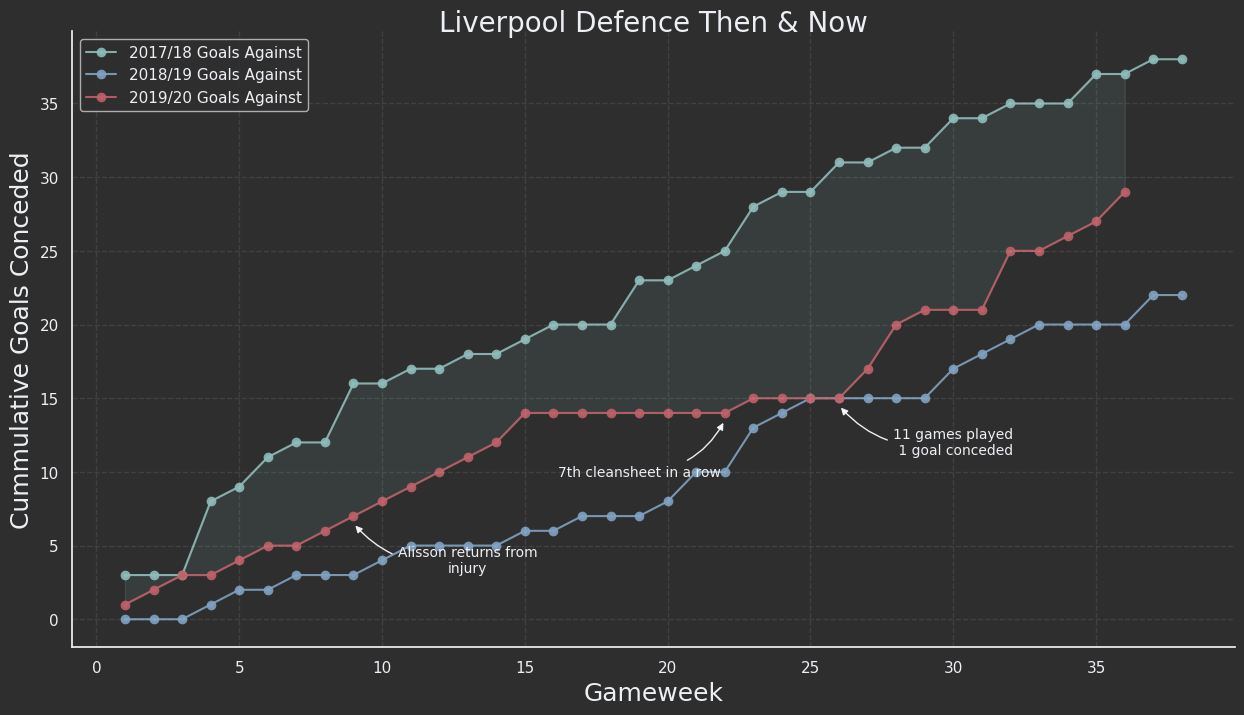

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(range(1, 39), cumsums.iloc[:38].GA, label= '2017/18 Goals Against', alpha=0.9, marker='.')
ax.plot(range(1, 39), cumsums.iloc[38:38*2].GA, label= '2018/19 Goals Against', alpha=0.9, marker='.')

games_in_19_20 = cumsums.iloc[38*2:].shape[0] 
print(games_in_19_20)
ax.plot(range(1, games_in_19_20+1), cumsums.iloc[38*2:].GA, label= '2019/20 Goals Against', alpha=0.9, marker='.')

ax.annotate("7th cleansheet in a row",
  xy=(22, 13.5), xycoords='data',
  xytext=(19, 10), textcoords='data',
  size=10, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                connectionstyle="arc3,rad=0.3",
                fc="w"),
)


ax.annotate("11 games played\n 1 goal conceded",
  xy=(26, 14.5), xycoords='data',
  xytext=(30, 12), textcoords='data',
  size=10, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                connectionstyle="arc3,rad=-0.3",
                fc="w"),
)


ax.annotate("Alisson returns from\ninjury",
  xy=(9, 6.5), xycoords='data',
  xytext=(13, 4), textcoords='data',
  size=10, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                connectionstyle="arc3,rad=-0.3",
                fc="w"),
)
ax.fill_between(range(1, games_in_19_20+1), cumsums.iloc[:games_in_19_20].GA, cumsums.iloc[38*2:].GA, alpha=0.1)


# plt.xticks(rotation=2)
# plt.yticks(rotation=-5)
plt.title('Liverpool Defence Then & Now')
plt.ylabel('Cummulative Goals Conceded')
plt.xlabel('Gameweek')
plt.legend()

# plt.savefig('Liverpool Defence Then & Now.png', dpi=300)
# files.download('Liverpool Defence Then & Now.png')
plt.show()

# Alisson Becker

In [23]:
adv_gk = fbref_dataframe('https://fbref.com/en/comps/9/keepersadv/Premier-League-Stats', table_id='stats_keeper_adv')
adv_gk

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,GA,PKA,FK,CK,OG,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp,Att,Cmp%,Att,Thr,Launch%,AvgLen,Att,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Matches
0,1,Adrián,es ESP,GK,Liverpool,32,1987,9.7,10,0,1,1,0,8.4,0.30,-1.6,-0.16,60,142,42.3,246,49,44.3,38.3,68,48.5,40.4,91,8,8.8,7,0.72,13.3,Matches
1,2,Alisson,br BRA,GK,Liverpool,26,1992,26.3,19,1,0,1,1,21.3,0.29,+3.3,+0.12,127,233,54.5,698,124,24.5,31.6,159,39.0,38.6,183,14,7.7,36,1.37,17.5,Matches
2,3,Kepa Arrizabalaga,es ESP,GK,Chelsea,24,1994,32.0,42,2,1,7,2,33.5,0.35,-6.5,-0.20,132,313,42.2,854,139,27.0,31.5,194,42.3,39.1,231,17,7.4,20,0.63,15.8,Matches
3,4,Claudio Bravo,cl CHI,GK,Manchester City,36,1983,3.9,7,0,0,0,0,4.2,0.28,-2.8,-0.73,19,47,40.4,104,13,27.9,31.5,28,64.3,48.2,35,3,8.6,1,0.26,12.4,Matches
4,5,Willy Caballero,ar ARG,GK,Chelsea,37,1981,4.0,7,0,0,3,1,5.5,0.36,-0.5,-0.13,23,59,39.0,103,10,45.6,35.7,22,54.5,42.5,18,0,0.0,2,0.50,12.8,Matches
5,6,Martin Dúbravka,sk SVK,GK,Newcastle Utd,30,1989,36.0,55,2,2,11,2,60.9,0.33,+7.9,+0.22,278,736,37.8,718,114,63.1,48.2,323,87.6,64.1,370,20,5.4,13,0.36,12.4,Matches
6,7,Ederson,br BRA,GK,Manchester City,25,1993,32.1,28,3,1,4,1,28.5,0.30,+1.5,+0.05,126,244,51.6,885,155,22.5,30.0,128,35.2,35.5,168,12,7.1,34,1.06,17.7,Matches
7,8,Łukasz Fabiański,pl POL,GK,West Ham,34,1985,20.5,31,3,1,2,2,28.8,0.29,-0.2,-0.01,191,442,43.2,419,80,68.3,49.8,166,94.0,65.4,208,7,3.4,4,0.19,11.6,Matches
8,9,Ralf Fährmann,de GER,GK,Norwich City,30,1988,0.2,1,1,0,0,0,1.3,0.31,+0.3,+1.23,1,3,33.3,7,2,42.9,29.7,3,0.0,16.0,4,0,0.0,0,0.00,7.0,Matches
9,10,Ben Foster,eng ENG,GK,Watford,36,1983,35.0,54,7,3,6,3,53.1,0.33,+2.1,+0.06,301,913,33.0,855,111,77.2,54.2,271,93.4,68.0,342,35,10.2,37,1.06,15.5,Matches


In [24]:
adv_gk['Goals Saved (PSxG+/-)'] = adv_gk['PSxG+/-'].astype(float)
adv_gk['90s'] = adv_gk['90s'].astype(float)
adv_gk['Goals Conceded'] = adv_gk['GA'].astype(int) 

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

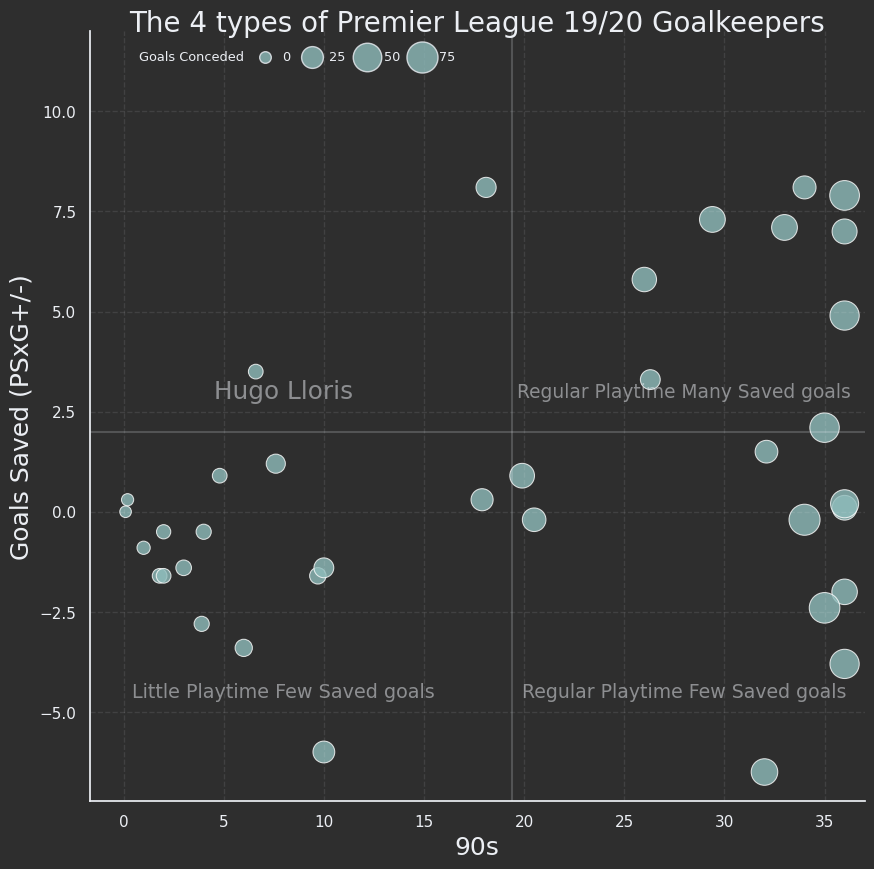

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    ax=ax,
    x='90s',
    y='Goals Saved (PSxG+/-)',
    size='Goals Conceded',
    sizes= (70, 500), 
    data= adv_gk,
    alpha=.8,
    s=300,
)

# Quadrants
ax.axhline(y=2, marker='', alpha=0.2)
ax.axvline(x=adv_gk['90s'].mean(), marker='', alpha=0.2)
quadrants = {
    'Hugo Lloris': (8, 3),
    'Regular Playtime Many Saved goals': (28, 3),
    'Little Playtime Few Saved goals': (8, -4.5),
    'Regular Playtime Few Saved goals': (28, -4.5),
}
for name, position in quadrants.items():
  ax.annotate(name, xy=position, size=20-len(name)*0.2, alpha=0.5, va='center', ha='center')



# Beautify
ax.legend(borderpad=1.0, ncol=5, columnspacing=0.7, handletextpad= 0.3, fontsize='xx-small', frameon=False)
ax.set_title('The 4 types of Premier League 19/20 Goalkeepers')
ax.set_ylim(top=12)
ax.set_xlim(right=37)
leg = ax.get_legend()
leg.markerscale = 0.1
for handle in leg.legendHandles:
  handle.set_color('#8fbcbbcc')
  handle.set_edgecolor('#eceff4cc')



# Annotations
commonargs = {
  'textcoords': 'data', 'xycoords': 'data',
  'size': 10, 'va': "center", 'ha': "center",
  'arrowprops': dict(arrowstyle="-|>",
                connectionstyle="arc3,rad=0.3",
                fc="w"),
}
# ax.annotate('Lloris', xy=(16, 8.6), xytext=(14, 8), **commonargs)
# ax.annotate('Vicente Guaita', xy=(32.5, 8.4), xytext=(30.5, 9), **commonargs)
# ax.annotate('McCarthy', xy=(23.2, 7.0), xytext=(21.5, 7.9), **commonargs)
# ax.annotate('Alisson', xy=(24.2, 4.6), xytext=(20.5, 3.9), **commonargs)
# ax.annotate('Ederson', xy=(29.8, 1.3), xytext=(27, 0.7), **commonargs)
# ax.annotate('Nick Pope', xy=(33.3, -2.6), xytext=(29.5, -2), **commonargs)
# ax.annotate('Adrian', xy=(9.7, -1.8), xytext=(7.5, -2.5), **commonargs)
# ax.annotate('Kepa', xy=(29.4, -5.4), xytext=(27.2, -6), **commonargs)

plt.savefig('4 types of premier league keepers.png', dpi=300)
files.download('4 types of premier league keepers.png')

# Trent + Robertson vs Walker + Mendy

In [26]:
def rad(degrees):
  return degrees*np.pi/180

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    # for d, (y1, y2) in zip(data[1:], ranges[1:]):
    #     assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, labels_radius,
                 n_ordinate_levels=8, labels_off=False, variables_font=14, ticks_font=12):
        angles = np.arange(0, 360, 360./len(variables))
        rad_angles = np.arange(0, 2*np.pi, 2*np.pi/len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        axes[0].set_thetagrids(angles, labels='')

        if not labels_off:
          for angle, variable in zip(angles, variables):
            axes[0].text(rad(angle), labels_radius, variable, fontsize=variables_font, rotation=angle-90, ha='center', va='center')

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(color='#342b38', alpha=0)
            ax.xaxis.set_visible(False)
            for i in range(1, len(variables)):
              ax.axvspan(i-0.2, i+0.2, facecolor='lightgrey', alpha=0.025)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabels = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabelss aren't reversed
                gridlabels = gridlabels[::-1]
                gridlabels[-1] = ''
            else:
              gridlabels[0] = ''
            
            l, txt = ax.set_rgrids(grid, labels='',
                         angle=angles[i])
            if not labels_off:
              for grid_value, label in zip(grid, gridlabels):
                ax.text(rad(angles[i]), grid_value, label, fontsize=ticks_font, rotation=angles[i]-90, ha='center', va='center')

            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

In [27]:
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.edgecolor': '#ffffff00',
 'axes.grid': True,
 'grid.color': '#595959',
 'grid.linewidth': '0.5',
 'axes.facecolor': '#2E2E2E',
 'axes.labelcolor': '#eceff4',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': '#2E2E2E',
 'lines.linewidth': 2.5,
 'lines.marker': '',
 'lines.markeredgewidth': 4.0,
  
 'patch.force_edgecolor': True,
 'text.color': '#eceff4',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
 'savefig.facecolor': '#2E2E2E',
 })

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


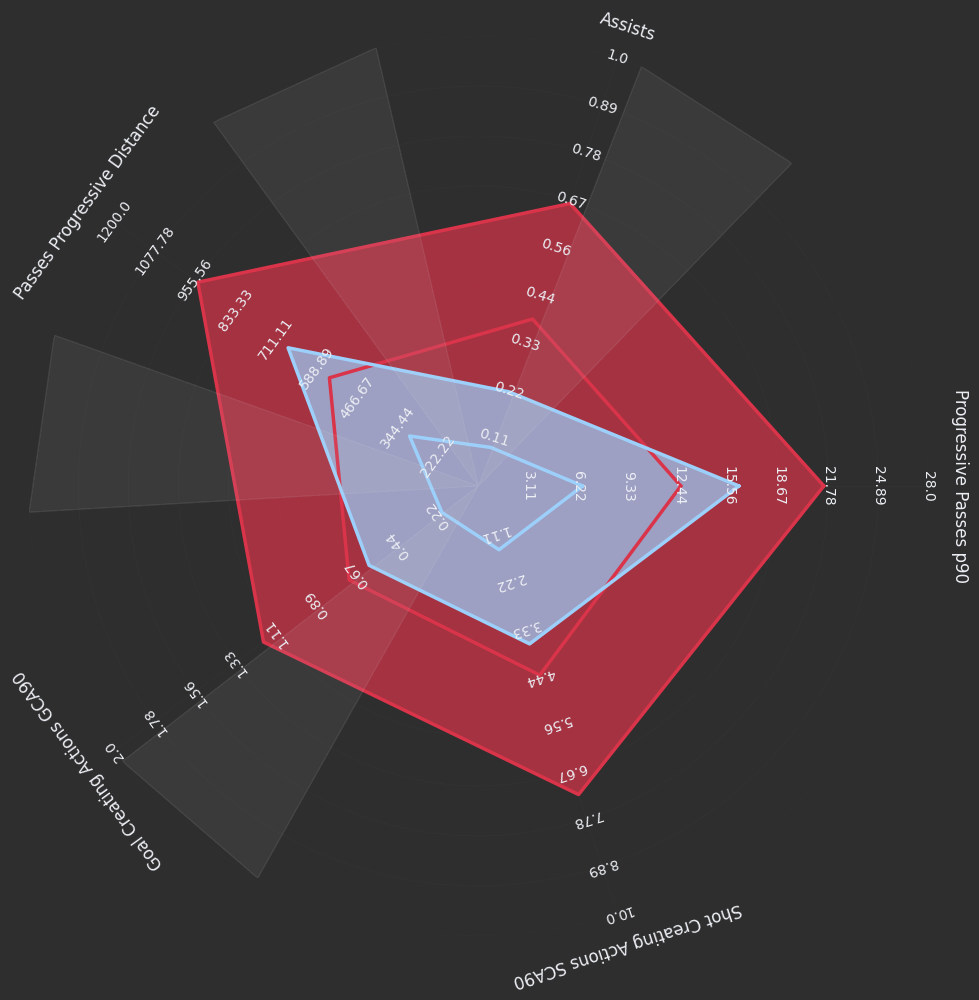

In [28]:
variables = ['Progressive Passes p90', 'Assists', 'Passes Progressive Distance', 'Goal Creating Actions GCA90', 'Shot Creating Actions SCA90']
trent =  np.array([12.6, 0.39, 549.9, 0.71, 4.42])
walker = np.array([6.49, 0.09, 307.7, 0.2, 1.49])
robbo = np.array([8.9, 0.27, 397.5, 0.47, 2.79])
mendy = np.array([9.73, 0.13, 367.0, 0.4, 2.2])

ranges = [(0, 28), (0, 1), (100, 1200), (0, 2), (0, 10)]

fig = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig, variables, ranges, 30, 10, variables_font=12, ticks_font=10)


colors = ['#d9344a', '#9cd0fb']

for player, color in zip([trent, walker], colors):
  radar.plot(player, color=color)

for player, color in zip([trent+robbo, walker+mendy], colors):
  radar.plot(player, color=color)
  radar.fill(player, alpha=0.7, color=color)

plt.show()